<a href="https://colab.research.google.com/github/h652-ui/NER-for-Medical-Records-using-BERT/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><b>SVM Classification</b></h1>
<br>
<p>Named Entity Recognition (NER) aims to
classify each word of a document into predefined target named entity classes and is nowadays considered to be fundamental for many
Natural Language Processing (NLP) tasks
such as information retrieval, machine translation, information extraction, question answering systems and others. </p> 

<h2><b>Word Embeddings Generation</b></h2>
<br>
<p>The following block includes two functions: <b>get_word_embedding</b> and <b>get_sentence_embedding</b>. Both these functions are used to convert the passed corpus into word embeddings. </p>

In [ ]:
!pip install transformers

import os
import pickle #For serialization of objects
import hashlib

import torch
import numpy as np
from transformers import BertTokenizer, BertModel 

# # load pre-trained tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model (weights)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True)
model.to(device)

# Run it in evaluation mode
model.eval()

def get_word_embedding(word_text):
    """ convert word_text into BERT embedding vector of size [3072]

    Concatenate the features of last four layers of all tokens 
    then take mean of that concatenated feature vector 
    """
    with torch.no_grad():
        word_text = word_text[:510]
        inputs = tokenizer(word_text, return_tensors="pt")
        outputs = model(**inputs)

        hidden_states = outputs[2]

        token_embeddings = torch.stack(hidden_states, dim=0)
        token_embeddings = torch.squeeze(token_embeddings, dim=1)
        token_embeddings = token_embeddings.permute(1,0,2)

        # Stores the token vectors, with shape [num_tokens x 3,072]
        token_vecs_cat = []
        # `token_embeddings` is a [num_tokens x 13 x 768] tensor.# For each token in the sentence...
        for i, token in enumerate(token_embeddings):
            # Concatenate the vectors from the last four layers.
            # Each layer vector is 768 values, so `cat_vec` is length 3,072.
            cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
            # Use `cat_vec` to represent `token`.
            token_vecs_cat.append(cat_vec)

        word_embedding = torch.stack(token_vecs_cat)
        word_embedding = torch.mean(word_embedding, dim=0)
        return word_embedding

def get_sentence_embedding(sentence_text):
    """ convert sentence_text into BERT embedding vector of size [768]

    Mean of all the tokens in second last layer 
    """

    hash_object = hashlib.sha256(sentence_text.encode('utf-8'))
    hex_dig = hash_object.hexdigest()

    embed_path = os.path.join("/content/drive/MyDrive/bert_cache/", str(hex_dig)+".pickle")

    if os.path.exists(embed_path):
        with open(embed_path, "rb") as f:
            return pickle.load(f)

    with torch.no_grad():
        sentence_text = sentence_text[:510]
        inputs = tokenizer(sentence_text, return_tensors="pt")
        outputs = model(**inputs.to(device))

        hidden_states = outputs[2]

        # sentence level embedding of 2nd last layer
        token_vecs = hidden_states[-2][0]
        sentence_embedding = torch.mean(token_vecs, dim=0)

        with open(embed_path, "wb") as f:
            pickle.dump(sentence_embedding, f)

        return sentence_embedding

     |████████████████████████████████| 3.1 MB 5.2 MB/s 
     |████████████████████████████████| 3.3 MB 25.4 MB/s 
     |████████████████████████████████| 895 kB 51.2 MB/s 
     |████████████████████████████████| 59 kB 6.7 MB/s 
     |████████████████████████████████| 596 kB 49.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<h2><b>Training Data Generation</b></h2>
<br>
<p>The program reads a data file and generates word embeddings from the text in that file.</p>

In [ ]:
!pip install pickle5
import pickle5 as pickle
import pandas as pd
import time

def generate_training_data(df_file_path, out_path):

    df = pd.read_csv(df_file_path,encoding='latin1')

    s1 = time.time()

    data = {}
    data["document"] = []
    data["features"] = []
    data["labels"] = []

    for row_no, row in df.iterrows():
        t1 = time.time()

        img_name = row['document']
        
        data["document"].append(row['document'])

        feature = {}
        feature["document"] = row['document']

        print()

        prev_words = get_sentence_embedding(str(row['prev_words'])).cpu().numpy()
        for i in range(prev_words.shape[0]):
            feature["prev_words_"+str(i)] = prev_words[i]

        next_words = get_sentence_embedding(str(row['next_words'])).cpu().numpy()
        for i in range(next_words.shape[0]):
            feature["next_words_"+str(i)] = next_words[i]

        word = get_sentence_embedding(str(row['text'])).cpu().numpy()
        for i in range(word.shape[0]):
            feature["word_"+str(i)] = word[i]
        
        feature["start_span"] = row['start_span']
        feature["end_span"] = row['end_span']
        
        feature["word_index"] = row['word_index_in_line']
        feature["line_length"] = row['line_length']

        data["features"].append(feature)
        data["labels"].append(row['label'])

        print(row_no+1, df['document'].size, "time:", time.time()-t1)

    print("total time", time.time()-s1)

    pickle_out = open(out_path,"wb")
    pickle.dump(data, pickle_out, pickle.HIGHEST_PROTOCOL)
    pickle_out.close()

    return data

def load_data(file_path):
    pickle_in = open(file_path, "rb")
    data = pickle.load(pickle_in)
    pickle_in.close()
    return data

     |████████████████████████████████| 256 kB 5.2 MB/s 


In [ ]:
data = generate_training_data("/content/Referral Letter_from.features.csv", "/content/Referral Letter_from.features.pickle")

Streaming output truncated to the last 5000 lines.
4449 6948 time: 0.008237123489379883

4450 6948 time: 0.0075893402099609375

4451 6948 time: 0.007312297821044922

4452 6948 time: 0.00705265998840332

4453 6948 time: 0.006638288497924805

4454 6948 time: 0.21979784965515137

4455 6948 time: 0.21001958847045898

4456 6948 time: 0.4738476276397705

4457 6948 time: 0.7671549320220947

4458 6948 time: 0.5277016162872314

4459 6948 time: 0.26951122283935547

4460 6948 time: 0.006808280944824219

4461 6948 time: 0.007697105407714844

4462 6948 time: 0.006740093231201172

4463 6948 time: 0.006852626800537109

4464 6948 time: 0.00708317756652832

4465 6948 time: 0.19672703742980957

4466 6948 time: 0.2760450839996338

4467 6948 time: 0.0063097476959228516

4468 6948 time: 0.009778261184692383

4469 6948 time: 0.006555795669555664

4470 6948 time: 0.006317138671875

4471 6948 time: 0.006585359573364258

4472 6948 time: 0.008306741714477539

4473 6948 time: 0.02014303207397461

4474 6948 time:


<h3><b>Split Data</b></h3>
<br>
<p>Split the generated data into training set and test set for training of model, and later for testing it.</p>

In [ ]:
def train_test_split(data, test_split_ratio=0.20):
    train_data = data.copy()
    test_data = data.copy()

    unique_doc = np.unique(data["document"])
    split = int(test_split_ratio*len(unique_doc))

    train_samples, test_samples = unique_doc[split:], unique_doc[:split]

    print("Total Documents:", len(unique_doc))
    print("Train Test:", len(train_samples), len(test_samples))
    
    train_ids = []
    for train_id in train_samples:
        indices = np.where(np.array(data["document"]) == train_id)[0]
        train_ids.extend(indices)

    for idx in train_data:
        train_data[idx] = list(np.array(train_data[idx])[train_ids])

    test_ids = []
    for test_id in test_samples:
        indices = np.where(np.array(data["document"]) == test_id)[0]
        test_ids.extend(indices)

    for idx in test_data:
        test_data[idx] = list(np.array(test_data[idx])[test_ids])

    return train_data, test_data

<h3><b>Label Data</b></h3>
<br>
<p>The following code provides the label of the word being passed into it, and returns 'O' if the word is not categorized in the list of known labels.</p>

In [ ]:
def label_process(label_str: object) -> object:
            priority = {
                'physician_name': 2187, 
                'degree': 1677, 
                'billing_number': 25, 
                'specialization': 903, 
                'facility': 1917, 
                'address': 2017, 
                'city': 1981, 
                'phone': 1929, 
                'fax_number': 1772, 
                'state': 1651, 
                'zip_code': 1680, 
                'provider_id': 224, 
                'npi': 1121
            }

            if label_str not in priority:
                return 'O'
            else:
                return label_str

In [ ]:
print("processing the data...")
train_data, valid_data = train_test_split(data)

X_train = pd.DataFrame(train_data["features"])
X_test = pd.DataFrame(valid_data["features"])

COLUMNS_TO_DROP = ['document']

X_train = X_train.drop(columns=COLUMNS_TO_DROP)
X_test = X_test.drop(columns=COLUMNS_TO_DROP)
print(X_train.keys())

y_train = np.array(train_data["labels"])
y_test = np.array(valid_data["labels"])


label_parsing = np.vectorize(label_process)
y_train = label_parsing(y_train)
y_test = label_parsing(y_test)

processing the data...
Total Documents: 404
Train Test: 324 80
Index(['prev_words_0', 'prev_words_1', 'prev_words_2', 'prev_words_3',
       'prev_words_4', 'prev_words_5', 'prev_words_6', 'prev_words_7',
       'prev_words_8', 'prev_words_9',
       ...
       'word_762', 'word_763', 'word_764', 'word_765', 'word_766', 'word_767',
       'start_span', 'end_span', 'word_index', 'line_length'],
      dtype='object', length=2308)


<h2><b>SVM Classifier</b></h2>

<p>A SVM Classifier is used to create categories within the dataset using the word embeddings.</p>

In [ ]:
from sklearn.svm import SVC
rbf_model = SVC(kernel='rbf')

In [ ]:
len(X_train)

5750

In [ ]:
len(X_test)

1198

In [ ]:
rbf_model.fit(X_train, y_train)

SVC()

In [ ]:

rbf_model.score(X_test,y_test)

0.46243739565943237

In [ ]:
linear_model = SVC(kernel='linear')
linear_model.fit(X_train,y_train)

SVC(kernel='linear')

In [ ]:
linear_model.score(X_test,y_test)

0.8831385642737897

In [ ]:
predictions = linear_model.predict(X_test)

In [ ]:
from sklearn.metrics import plot_confusion_matrix

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


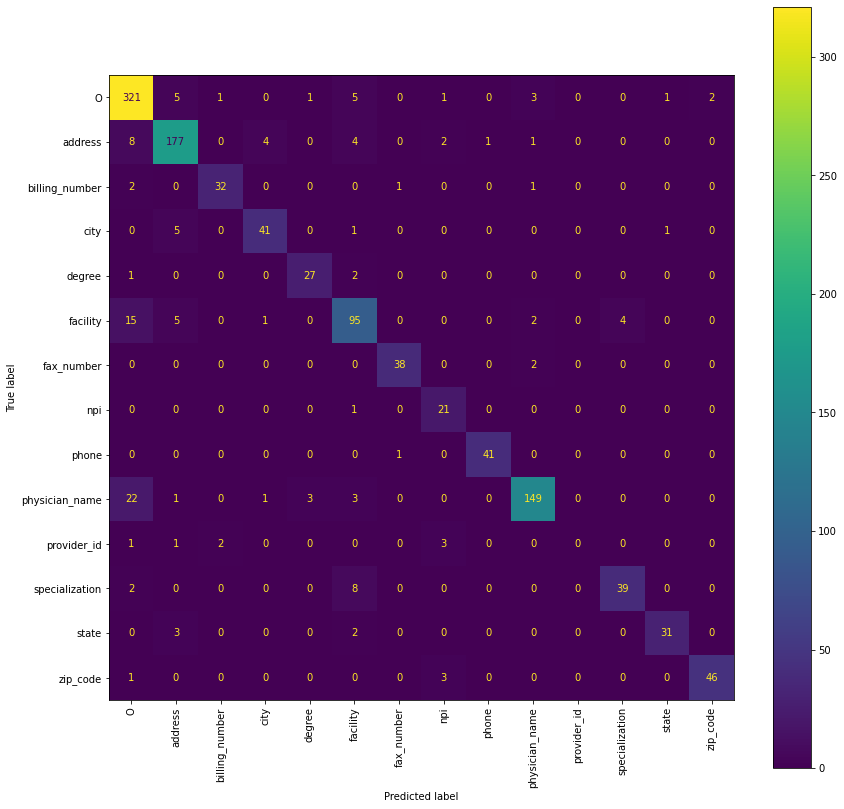

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(14, 14))
plot_confusion_matrix(linear_model, X_test, y_test, ax=ax, xticks_rotation="vertical")

In [ ]:
from sklearn.metrics import classification_report


In [ ]:
print(classification_report(y_test,predictions))

                precision    recall  f1-score   support

             O       0.86      0.94      0.90       340
       address       0.90      0.90      0.90       197
billing_number       0.91      0.89      0.90        36
          city       0.87      0.85      0.86        48
        degree       0.87      0.90      0.89        30
      facility       0.79      0.78      0.78       122
    fax_number       0.95      0.95      0.95        40
           npi       0.70      0.95      0.81        22
         phone       0.98      0.98      0.98        42
physician_name       0.94      0.83      0.88       179
   provider_id       0.00      0.00      0.00         7
specialization       0.91      0.80      0.85        49
         state       0.94      0.86      0.90        36
      zip_code       0.96      0.92      0.94        50

      accuracy                           0.88      1198
     macro avg       0.83      0.83      0.82      1198
  weighted avg       0.88      0.88      0.88 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
